In [6]:
%pip install bintrees
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.widgets import PolygonSelector
from matplotlib.patches import Polygon
from matplotlib.collections import LineCollection
from bitalg.visualizer.main import Visualizer
from bintrees import AVLTree
import numpy as np
import time
mpl.rcParams['figure.max_open_warning'] = False
%matplotlib notebook
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


# Zadawanie wielokąta

<IPython.core.display.Javascript object>


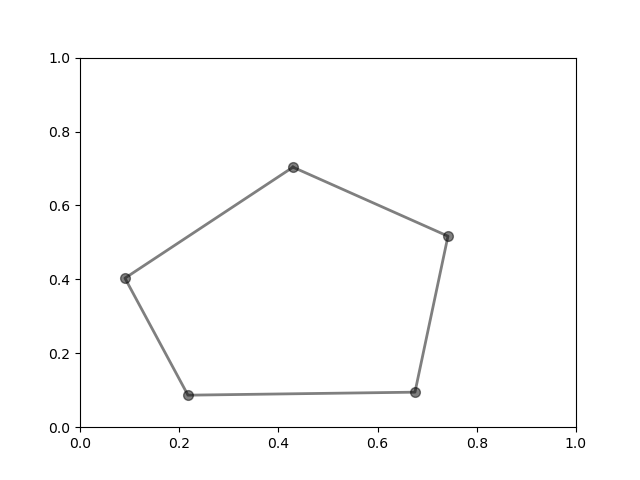

'\nNależy uruchomić kod i zadawać kolejne wierzchołki za pomocą myszki w kierunku odwrotnym do ruchu wskazówek zegara\n'

In [7]:
fig, ax = plt.subplots()
selector = PolygonSelector(ax, lambda vs: print(vs))
"""
Należy uruchomić kod i zadawać kolejne wierzchołki za pomocą myszki w kierunku odwrotnym do ruchu wskazówek zegara
"""

# Kategoryzowanie punktów

In [3]:
def orient(a, b, c):
    r"""Oblicza :math:`\lvert\vec{AB} \times \vec{AC}\rvert` w celu wyznaczenia orientacji
    punktu :math:`C` względem odcinka :math:`AB`.

    Args:
        a ((float, float)): Współrzędne punktu :math:`A`
        b ((float, float)): Współrzędne punktu :math:`B`
        c ((float, float)): Współrzędne punktu :math:`C`

    Returns:
        float: Zorientowana powierzchnia równoległoboku tworzonego przez wektory :math:`AB` oraz :math:`AC`
    """
    return a[0]*b[1]+a[1]*c[0]+b[0]*c[1]-b[1]*c[0]-a[0]*c[1]-a[1]*b[0]

def categorize_points(points): 
    """Dzieli wielokąt na zbiory punktów początkowych, końcowych, łączących, dzielących i prawidłowych.

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków
            podanych w kolejności odwrotnej do ruchu wskazówek zegara

    Returns:
        (list((float, float)), list((float, float)), list((float, float)), list((float, float)), list((float, float))): Zbiory punktów:
            początkowych, końcowych, łączących, dzielących i prawidłowych
    """
    start = set()
    end = set()
    merge = set()
    split = set()
    regular = set()
    n = len(points)
    for i, current in enumerate(points):
        next = points[(i+1)%n]
        prev = points[i-1]
        if prev[1] <= current[1] and next[1] <= current[1]:
            if orient(prev, current, next) > 0:
                start.add(current)
            else:
                split.add(current)
        elif prev[1] >= current[1] and next[1] >= current[1]:
            if orient(prev, current, next) > 0:
                end.add(current)
            else:
                merge.add(current)
        else: regular.add(current)
    return start, end, merge, split, regular

In [56]:
def present_categorized(points, title):
    """Przedstawia na wykresie podział punktów wielokąta.

    Wierzchołki kolorowane są następująco:
    - początkowe - zielony
    - końcowe - czerwony
    - łączące - niebieski
    - dzielące - turkusowy
    - prawidłowe - brązowy

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        title (:obj:`str`): Tytuł wykresu
    """
    fig, ax = plt.subplots()
    ax.set_title(title)
    start_time = time.time()
    start, end, merge, split, regular = map(lambda x: np.array(list(x)), categorize_points(points))
    execution_time = time.time() - start_time
    ax.add_patch(Polygon(points, fc='none', ec='k'))
    if len(start) > 0:
        ax.scatter(start[:,0], start[:,1], c='g')
    if len(end) > 0:
        ax.scatter(end[:,0], end[:,1], c='r')
    if len(merge) > 0:
        ax.scatter(merge[:,0], merge[:,1], c='b')
    if len(split) > 0:
        ax.scatter(split[:,0], split[:,1], c='c')
    if len(regular) > 0:
        ax.scatter(regular[:,0], regular[:,1], c='tab:brown')
    print(f"{title}: {execution_time}s, {len(start)}/{len(end)}/{len(merge)}/{len(split)}/{len(regular)}")

Rodzaje punktów: 7.390975952148438e-05s, 1/1/0/0/6


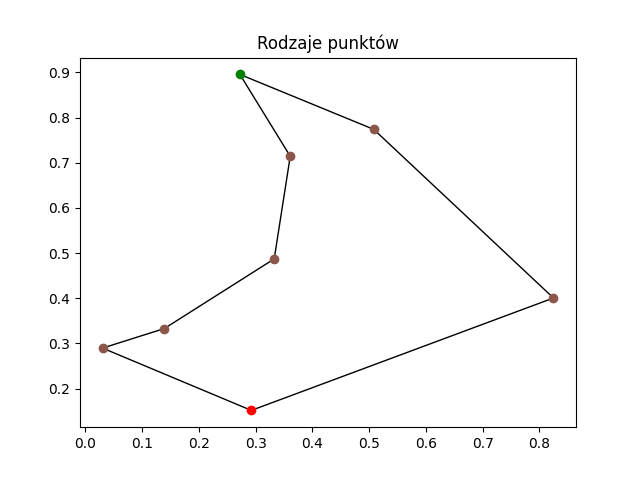

In [169]:
present_categorized(selector.verts, "Rodzaje punktów")

## Test $y$-monotoniczności

In [6]:
def y_monotone(points):
    """Sprawdza czy wielokąt :math:`P` jest y-monotoniczny.

    Wykorzystuje wewnętrznie :func:`~categorize_points`.

    Args:
        points (list((float, float))): Wielokąt :math:`P` przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara

    Returns:
        bool
    """
    _, _, connecting, dividing, _ = categorize_points(points)
    return len(connecting) == len(dividing) == 0

In [161]:
y_monotone(selector.verts)

True

# Triangulacja wielokąta monotonicznego

In [8]:
def inside_polygon(a, b, c, left):
    r"""Sprawdza czy :math:`\triangle ABC` leży wewnątrz danego wielokąta.

    Poza trójkątem potrzebna jest tylko wiedza o jednym z łańcuchów wielokąta.

    Args:
        a ((float, float)): Punkt :math:`A`
        b ((float, float)): Punkt :math:`B`
        c ((float, float)): Punkt :math:`C`
        left (set((float, float))): Lewy łańcuch wielokąta

    Returns:
        bool
    """
    if a in left:
        return orient(a, b, c) < 0
    else:
        return orient(a, b, c) > 0

def triangulate_monotone(points, on_check=lambda line: None, on_new=lambda line: None):
    """Przeprowadza triangulację wielokąta y-monotonicznego.

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        on_check (((float, float), (float, float)) -> None, optional): Funkcja wywoływana podczas analizowania nowej przękątnej
        on_new (((float, float), (float, float)) -> None, optional): Funkcja wywoływana podczas dodawania nowej przękątnej do zbioru wynikowego

    Returns:
        set(((float, float), (float, float))): Triangulacja wielokąta
    """
    n = len(points)
    sorted_points = sorted(points, key=lambda x: x[0])
    sorted_points.sort(key=lambda x: x[1], reverse=True)
    
    first = points.index(sorted_points[0])
    last = points.index(sorted_points[-1])
    i = first
    right = set()
    while i != last:
        right.add(points[i])
        i = (i+1)%n
    i = last
    left = set()
    while i != first:
        left.add(points[i])
        i = (i+1)%n
    stack = [sorted_points[0], sorted_points[1]]
    lines = set()
    for i in range(2, n-1):
        if (stack[-1] in left and sorted_points[i] in right) or (stack[-1] in right and sorted_points[i] in left):
            while len(stack) > 1:
                last = stack.pop()
                line = (sorted_points[i], last)
                lines.add(line)
                on_check(line)
                on_new(line)
            last = stack.pop()
            on_check((sorted_points[i], last))
            stack.append(sorted_points[i-1])
            stack.append(sorted_points[i])
        else:
            last = stack.pop()
            on_check((sorted_points[i], last))
            while stack and inside_polygon(sorted_points[i], stack[-1], last, left):
                last = stack.pop()
                line = (sorted_points[i], last)
                lines.add(line)
                on_check(line)
                on_new(line)
            if stack: on_check((sorted_points[i], stack[-1]))
            stack.append(last)
            stack.append(sorted_points[i])
    first = stack.pop()
    on_check((sorted_points[-1], first))
    last = stack.pop()
    while stack:
        line = (sorted_points[-1], last)
        lines.add(line)
        on_check(line)
        on_new(line)
        last = stack.pop()
    on_check((sorted_points[-1], last))
    return lines

In [9]:
def visualize_triangulation(points, title):
    """Przeprowadza triangulację wielokąta y-monotonicznego i zapisuje wizualizację w formacie gif.

    Aktywnie rozpatrywana przękątna przedstawiona jest w kolorze pomarańczowym, a przekątne dołączone
    do triangulacji w kolorze zielonym.

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        title (:obj:`str`): Nazwa pliku
    """
    def on_check(line):
        ls = vis.add_line_segment(line, color='orange')
        vis.remove_figure(ls)
    def on_new(line):
        vis.add_line_segment(line, color='green')
    vis = Visualizer()
    vis.add_point(points)
    vis.add_polygon(points, fc='none', ec='k')
    lines = triangulate_monotone(points, on_check, on_new)
    vis.save_gif(title)

In [171]:
visualize_triangulation(selector.verts, 'monotone')

# Podział na wielokąty monotoniczne

In [11]:
class Edge:
    r"""Bok wielokąta, przedstawiony jako odcinek :math:`\overline{\rm AB}`.

    Attributes:
        a ((float, float)): Współrzędne lewego wierzchołka
        b ((float, float)): Współrzędne prawego wierzchołka
        m (float, optional): Współczynnik kierunkowy prostej :math:`AB`
        k (float, optional): Wyraz wolny prostej :math:`AB`
    """
    sweep_line = float('inf')
    """float: współrzędna y miotły.

    Wartość wykorzystywana w :func:`~partition`.
    """
    def __init__(self, a, b):
        if a[0] >= b[0]:
            a, b = b, a
        self.a = tuple(a)
        self.b = tuple(b)
        if a[0] != b[0]:
            self.m = (self.a[1]-self.b[1])/(self.a[0]-self.b[0])
            self.k = self.a[1]-self.m*self.a[0]
    def sweep_line_x_intersect(self):
        """Oblicza współrzędną x przecięcia z miotłą.

        Returns:
            float
        """
        return (Edge.sweep_line-self.k)/self.m if self.a[0] != self.b[0] else self.a[0]
    def other(self, x):
        """Zwraca ten z wierzchołków :math:`A` lub :math:`B` który jest różny od podanego.

        Args:
            x ((float, float)): Wierzchołek :math:`A` lub :math:`B`

        Returns:
            ((float, float)): Wierzchołek różny od podanego.
        """
        if self.a == x:
            return self.b
        return self.a
    def __eq__(self, other):
        return self.a == other.a and self.b == other.b
    def __lt__(self, other):
        return self.sweep_line_x_intersect() < other.sweep_line_x_intersect()
    def __hash__(self):
        return hash((self.a, self.b))
    def __repr__(self):
         return f"Edge({self.a}, {self.b})"

class Event:
    """Zdarzenie w kolejce reprezentujące wierzchołek wielokąta prostego.

    Wykorzystywane w algorytmie podziału wielokąta prostego na wielokąty monotoniczne.

    Attributes:
        idx (int): Unikatowy identyfikator wierzchołka
        point ((float, float)): Współrzędne wierzchołka
        prev ((float, float)): Współrzędne poprzedniego wierzchołka w wielokącie (w kolejności przeciwnej do ruchu wskazówek zegara)
        e_l (:obj:`Edge`): Lewa krawędź o końcu w wierzchołku
        e_r (:obj:`Edge`): Prawa krawędź o końcu w wierzchołku
    """
    def __init__(self, point, prev, idx, e_l, e_r):
        self.idx = idx
        self.point = tuple(point)
        self.prev = tuple(prev)
        self.e_l = e_l
        self.e_r = e_r
    def __eq__(self, other):
        return self.point == other.point
    def __lt__(self, other):
        return self.point[1] > other.point[1] if self.point[1] != other.point[1] else self.point[0] < other.point[0]
    def __hash__(self):
        return hash(self.point)
    def __repr__(self):
         return f"Event({self.point})"

class BalancedTree:
    """Zbalansowane drzewo poszukiwań binarnych.

    Klasa ułatwiająca korzystanie z :obj:`AVLTree`.

    Attributes:
        tree (:obj:`AVLTree`): Ukryta implementacja struktury drzewa
        on_add (object -> None, optional): Funkcja wywoływana podczas dodawania nowego obiektu
        on_remove (object -> None, optional): Funkcja wywoływana podczas usuwania obiektu
    """
    def __init__(self, on_add = lambda x: None, on_remove = lambda x: None):
        self.tree = AVLTree()
        self.on_add = on_add
        self.on_remove = on_remove
    def __repr__(self):
        return self.tree.__repr__()
    def __len__(self):
        return len(self.tree)
    def __iter__(self):
        return self.tree.__iter__()
    def insert(self, val):
        """Dodaje nowy element do drzewa.
    
        Wywołuje funkcję :func:`~self.on_add`.
    
        Args:
            val (object): Porównywalna wartość, którą należy umieścić w strukturze
    
        Returns:
            None
        """
        self.tree.insert(val, None)
        self.on_add(val)
    def remove(self, val):
        """Usuwa element z drzewa, jeśli taki istnieje.

        Jeśli element zostaje usunięty, wywołuje funkcję :func:`~self.on_remove`.

        Args:
            val (object): Porównywalna wartość, którą należy usunąć ze struktury

        Returns:
            None
        """
        try:
            self.tree.remove(val)
            self.on_remove(val)
        except:
            return
    def pop(self):
        """Usuwa pierwszą w porządku leksykograficznym wartość drzewa i zwraca ją.

        Wywołuje funkcję :func:`~self.on_remove`.

        Returns:
            object: Usunięty element

        Raises:
            KeyError: Jeżeli drzewo jest puste.
        """
        val = self.tree.pop_min()[0]
        self.on_remove(val)
        return val
    def pop_max(self):
        """Usuwa ostatnią w porządku leksykograficznym wartość drzewa i zwraca ją.

        Wywołuje funkcję :func:`~self.on_remove`.

        Returns:
            object: Usunięty element

        Raises:
            KeyError: Jeżeli drzewo jest puste.
        """
        val = self.tree.pop_max()[0]
        self.on_remove(val)
        return val
    def floor(self, val):
        """Zwraca ostatnią w porządku leksykograficznym wartość drzewa mniejszą lub równą podanej.

        Args:
            val (object): Porównywalna wartość, ogranicząjąca poszukiwanie od góry

        Returns:
            object: Znaleziona wartość

        Raises:
            KeyError: Jeżeli nie zostanie znaleziona żadna wartość ograniczona od góry przez val.
        """
        return self.tree.floor_key(val)

In [51]:
def event_queue(points, end, split, on_add, on_remove):
    """Tworzy strukturę kolejki dla algorytmu zaimplementowanego w :func:`~partition`.

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        end (set((float, float))): Wierzchołki kończące
        split (set((float, float))): Wierzchołki dzielące
        on_add ((float, float) -> None): Funkcja wywoływana podczas dodawania nowego wierzchołka
        on_remove ((float, float) -> None): Funkcja wywoływana podczas usuwania wierzchołka

    Returns:
        :obj:`BalancedTree`: Kolejka obiektów :obj:`Event`
    """
    queue = BalancedTree(on_add, on_remove)
    n = len(points)
    for i, point in enumerate(points):
        next = points[(i+1)%n]
        prev = points[i-1]
        e_l, e_r = None, None
        if point in end or point in split:
            e_l = Edge(prev, point)
            e_r = Edge(point, next)
        else:
            e_l = Edge(next, point)
            e_r = Edge(point, prev)
        queue.insert(Event(point, prev, i, e_l, e_r))
    return queue

In [58]:
def partition(points, on_result_add = lambda e: None, on_sweep = lambda y: None, on_Q_add = lambda v: None, on_Q_remove = lambda v: None, on_T_add = lambda e: None , on_T_remove = lambda e: None, eps = 1e-8):
    """Dzieli podany wielokąt na wielokąty monotoniczne za pomocą zawartych w nim przekątnych,

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        on_result_add (((float, float), (float, float)) -> None, optional): Funkcja wywoływana podczas dodania nowej przekątnej
        on_sweep (float -> None, optional): Funkcja wywoływana przy zmianie współrzędnej y miotły
        on_Q_add (:obj:`Event` -> None, optional): Funkcja wywoływana podczas dodawania wierzchołka do kolejki
        on_Q_remove (:obj:`Event` -> None, optional): Funkcja wywoływana podczas usuwania wierzchołka z kolejki
        on_T_add (:obj:`Edge` -> None, optional): Funkcja wywoływana podczas dodawania krawędzi do struktury stanu
        on_T_remove (:obj:`Edge` -> None, optional): Funkcja wywoływana podczas usuwania krawędzi ze struktury stanu
        eps (float, optional): Tolerancja dla zera

    Returns:
        set((int, int)): Przekątna dzielące wielokąt na wielokąty monotoniczne wyrażone jako pary indeksów wierzchołków w liście points
    """
    def e(v, T, eps):
        fake_v = (v.point[0]-eps, Edge.sweep_line)
        return T.floor(Edge(fake_v, fake_v))   
    def result_add(a, b, result):
        e = (a.idx, b.idx)
        result.add(tuple(sorted(e)))
        on_result_add((a.point, b.point))
    result = set()
    T = BalancedTree(on_T_add, on_T_remove)
    start, end, merge, split, _ = categorize_points(points)
    Q = event_queue(points, end, split, on_Q_add, on_Q_remove)
    helper = dict()
    for v in Q:
        helper[v.e_l] = None
        helper[v.e_r] = None
    while len(Q):
        v = Q.pop()
        Edge.sweep_line = v.point[1]
        on_sweep(v.point[1])
        if v.point in start:
            T.insert(v.e_l)
            helper[v.e_l] = v
            continue
        if v.point in end:
            if helper[v.e_l] and helper[v.e_l].point in merge:
                result_add(v, helper[v.e_l], result)
            T.remove(v.e_l)
            continue
        if v.point in split:
            e_v = e(v, T, eps)
            result_add(v, helper[e_v], result)
            helper[e_v] = v
            T.insert(v.e_r)
            helper[v.e_r] = v
            continue
        if v.point in merge:
            if helper[v.e_r] and helper[v.e_r].point in merge:
                result_add(v, helper[v.e_r], result)
            T.remove(v.e_r)
            e_v = e(v, T, eps)
            if helper[e_v] and helper[e_v].point in merge:
                result_add(v, helper[e_v], result)
            helper[e_v] = v
            continue
        e_u, e_d = None, None
        if v.e_r.other(v.point)[1] > v.point[1]:
            e_u, e_d = v.e_r, v.e_l
        else:
            e_u, e_d = v.e_l, v.e_r
        if v.prev[1] > v.point[1]:
            if helper[e_u] and helper[e_u].point in merge:
                result_add(v, helper[e_u], result)
            T.remove(e_u)
            T.insert(e_d)
            helper[e_d] = v
        else:
            e_v = e(v, T, eps)
            if helper[e_v] and helper[e_v].point in merge:
                result_add(v, helper[e_v], result)
            helper[e_v] = v
    return result

In [157]:
def visualize_partition(points, title):
    """Przeprowadza podział wielokąta prostego na wielokąty y-monotoniczne i zapisuje wizualizację w formacie gif.

    Miotła przedstawiona jest w kolorze zielonym, Wierzchołki w kolejce w kolorze czerwonym,
    a struktura stanu w kolorze niebieskim.

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        title (:obj:`str`): Nazwa pliku
    """
    vis = Visualizer()
    sweep = None
    Q = dict()
    T = dict()
    def on_sweep(y):
        nonlocal sweep
        if sweep is not None:
            vis.remove_figure(sweep)
        sweep = vis.add_line(((0, y), (1, y)), color="green")
    def on_Q_add(v):
        point = vis.add_point(v.point, color="red")
        Q[v] = point
    def on_Q_remove(v):
        point = Q.pop(v)
        vis.remove_figure(point)
    def on_T_add(e):
        ls = vis.add_line_segment((e.a, e.b), color="blue")
        T[e] = ls
    def on_T_remove(e):
        ls = T.pop(e)
        vis.remove_figure(ls)
    def on_result_add(e):
        vis.add_line_segment(e, color="green")
    vis.add_point(points)
    vis.add_polygon(points, fc='none', ec='k')
    partition(points, on_result_add, on_sweep, on_Q_add, on_Q_remove, on_T_add, on_T_remove)
    vis.save_gif(title)

In [158]:
visualize_partition(selector.verts, 'partition')

In [155]:
def present_set(points, title):
    """Przedstawia na wykresie podany wielokąt.

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        title: (:obj:`str`): Tytuł wykresu
    """
    points = np.array(points)
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.add_patch(Polygon(points, fc='none', ec='k'))
    ax.scatter(points[:,0], points[:,1], s=5)

def present_partition(points, title):
    """Przedstawia na wykresie podany wielokąt oraz przekątne dzielące go na wielokąty y-monotoniczne.

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        title: (:obj:`str`): Tytuł wykresu
    """
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.add_patch(Polygon(points, fc='none', ec='k'))
    ax.scatter(np.array(points)[:,0], np.array(points)[:,1], s=5)
    start = time.time()
    line_indexes = partition(points)
    execution_time = time.time() - start
    lines = [(points[e[0]], points[e[1]]) for e in line_indexes]
    ax.add_collection(LineCollection(lines, linewidth=1))
    print(f"{title}: {execution_time}s, {len(lines)} krawędzi")
    
def present_monotone_triangulation(points, title):
    """Przedstawia na wykresie podany wielokąt y-monotoniczny oraz przekątne składające się na jego triangulację.

    Args:
        points (list((float, float))): Wielokąt y-monotoniczny przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        title: (:obj:`str`): Tytuł wykresu
    """
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.add_patch(Polygon(points, fc='none', ec='k'))
    ax.scatter(np.array(points)[:,0], np.array(points)[:,1], s=5)
    start = time.time()
    lines = triangulate_monotone(points)
    execution_time = time.time() - start
    ax.add_collection(LineCollection(lines, linewidth=1))
    print(f"{title}: {execution_time}s, {len(lines)} krawędzi")

Zadane: 0.0026330947875976562s, 8 krawędzi


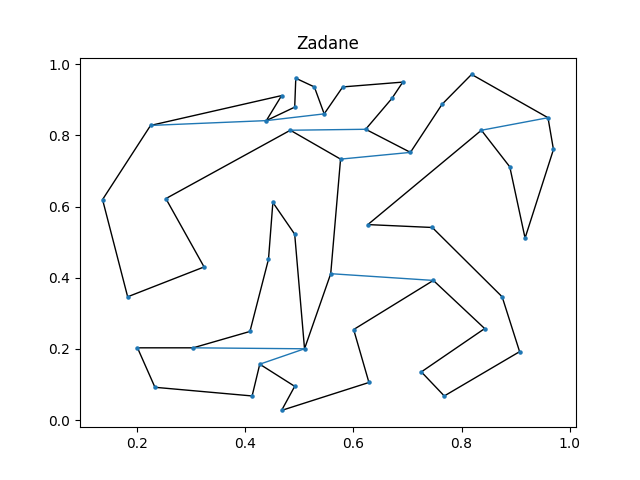

In [156]:
present_partition(selector.verts, "Zadane")

In [173]:
def split_polygon(points, diagonals):
    """Dzieli wielokąt prosty na mniejsze wielokąty wykorzystując podane przekątne.

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        diagonals (set((int, int))): Nieprzecinające się przekątne wyrażone jako pary indeksów wierzchołków
            w liście points

    Returns:
        list(list((float, float))): Lista wielokątów przedatwionych jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
    """
    n = len(points)
    def arc_length(d):
        return min(d[1]-d[0], n-d[1]+d[0])
    def traverse(points, next, start, end):
        current = start
        polygon = []
        while current != end:
            polygon.append(points[current])
            prev = current
            current = next[current]
            next[prev] = None
        polygon.append(points[end])
        return polygon
    diagonals = sorted(diagonals, key=arc_length)
    next = [(i+1)%n for i in range(n)]
    polygons = []
    for d in diagonals:
        start, end = d[0], d[1]
        if n-d[1]+d[0] < d[1]-d[0]:
            start, end = end, start
        polygons.append(traverse(points, next, start, end))
        next[start] = end
    for i in range(n):
        if next[i] is not None:
            final = traverse(points, next, next[i], i)
            polygons.append(final)
            break
    return polygons
        
def triangulate(points):
    """Przeprowadza triangulację wielokąta prostego metodą podziału na wielokąty monotoniczne.

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara

    Returns:
        set(((float, float), (float, float))): Triangulacja wielokąta
    """
    diagonals = partition(points)
    polygons = split_polygon(points, diagonals)
    result = [(points[i], points[j]) for i, j in diagonals]
    for polygon in polygons:
        result.extend(triangulate_monotone(polygon))
    return result

In [149]:
def present_full_triangulation(points, title):
    """Przedstawia na wykresie podany wielokąt prosty oraz jego triangulację.

    Args:
        points (list((float, float))): Wielokąt przedatwiony jako lista współrzędnych wierzchołków 
            podanych w kolejności odwrotnej do ruchu wskazówek zegara
        title: (:obj:`str`): Tytuł wykresu
    """
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.add_patch(Polygon(points, fc='none', ec='k'))
    ax.scatter(np.array(points)[:,0], np.array(points)[:,1], s=5)
    start = time.time()
    lines = triangulate(points)
    execution_time = time.time() - start
    ax.add_collection(LineCollection(lines, linewidth=1))
    print(f"{title}: {execution_time}s, {len(lines)} krawędzi")

t: 0.00028228759765625s, 0 krawędzi
title: 0.0002715587615966797s, 5 krawędzi


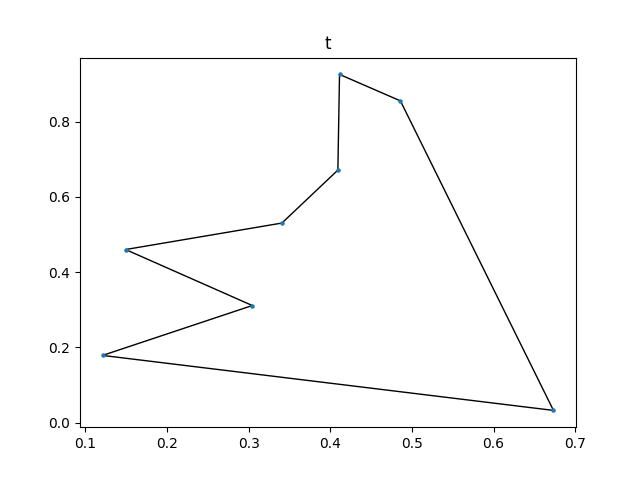

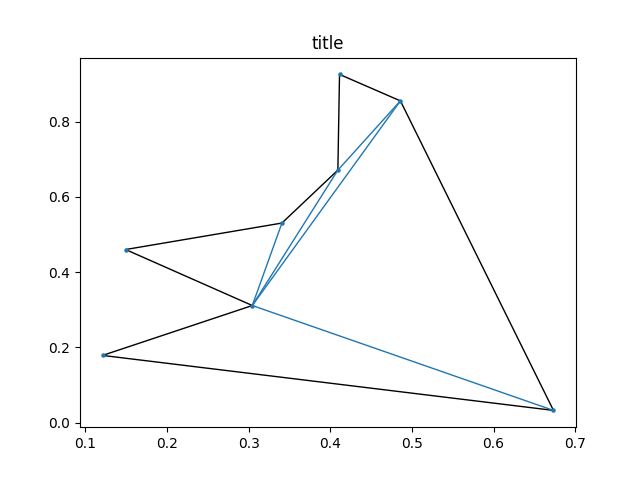

In [177]:
present_partition(selector.verts, "t")
present_full_triangulation(selector.verts, "title")

# Triangulacja Delaunay'a

In [192]:
def is_in_triangle(p, p1, p2, p3, eps=1e-9): 
    """funkcja sprawdza, czy dany punkt p znajduje się w środku trójkąta"""
    def sign(p1, p2, p3):
        return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
        
    d1 = sign(p, p1, p2)
    d2 = sign(p, p2, p3)
    d3 = sign(p, p3, p1)

    has_neg = (d1 < -eps) or (d2 < -eps) or (d3 < -eps)
    has_pos = (d1 > eps) or (d2 > eps) or (d3 > eps)
        
    return not (has_neg and has_pos)

def find_triangle(p, T): 
    """funkcja znajduje trójkąt, we wnętrzu którego jest dany punkt"""
    for i in range (len(T)):
        p1, p2, p3 = T[i]
        if is_in_triangle(p, p1, p2, p3):
            return T[i], i

def on_triangle_edge(p, t, epsilon=1e-9): 
    """funkcja sprawdza, czy punkt jest na krawędzi trójkąta, zakładamy, że punkt nie może być poza trójkątem"""
    p1, p2, p3 = t

    def point_on_line(p, a, b, epsilon):
        cross_product = (p[1] - a[1]) * (b[0] - a[0]) - (p[0] - a[0]) * (b[1] - a[1])
        if abs(cross_product) > epsilon:
            return False
        return True
        
    return (
        point_on_line(p, p1, p2, epsilon) or
        point_on_line(p, p2, p3, epsilon) or
        point_on_line(p, p3, p1, epsilon)
    )

def on_which_edge(P, A, B, C, eps=1e-9): 
    """funkcja sprawdza, na której krawędzi trójkąta znajduje się punkt, 2 pierwsze elementy wyniku to 2 wierzcholki tej krawędzi"""
    def is_on_edge(P, X, Y):
        cross_product = (P[0] - X[0]) * (Y[1] - X[1]) - (P[1] - X[1]) * (Y[0] - X[0])
        if abs(cross_product) > eps: 
            return False
        
        dot_product = (P[0] - X[0]) * (Y[0] - X[0]) + (P[1] - X[1]) * (Y[1] - X[1])
        squared_length = (Y[0] - X[0]) ** 2 + (Y[1] - X[1]) ** 2
        return 0 <= dot_product <= squared_length
    
    if is_on_edge(P, A, B):
        return A, B, C
    elif is_on_edge(P, B, C):
        return B, C, A
    elif is_on_edge(P, C, A):
        return C, A, B
    else:
        raise ValueError("Punkt P nie leży na żadnej krawędzi, co nie powinno się zdarzyć.")

def find_triangle_with_edge(p, edge, T): 
    """funkcja znajduje drugi trójkąt w triangulacji zawierający krawędź edge"""
    A, B = edge
    n = len(T)
    for i in range(n):
        triangle = T[i]
        if A in triangle and B in triangle and p not in triangle:
            remaining_point = next(pt for pt in triangle if pt not in edge)
            return T[i], i, remaining_point

def min_angle(A, B, C): 
    """funkcja oblicza minimalny kąt trójkąta"""
    def length_squared(P, Q):
        return (P[0] - Q[0])**2 + (P[1] - Q[1])**2
    
    def angle(opposite, side1, side2):
        return np.acos((side1 + side2 - opposite) / (2 * np.sqrt(side1) * np.sqrt(side2)))
    
    a2 = length_squared(B, C)
    b2 = length_squared(A, C)
    c2 = length_squared(A, B)

    angle_A = angle(a2, b2, c2)
    angle_B = angle(b2, a2, c2)
    angle_C = angle(c2, a2, b2)

    return min(angle_A, angle_B, angle_C)

def is_concave(A, B, C, D):
    
    return is_in_triangle(A, B, C, D) or is_in_triangle(B, A, C, D) or is_in_triangle(C, B, A, D) or is_in_triangle(D, B, C, A)

def is_illegal(p, edge, r, dummy): 
    """funkcja sprawdza, czy krawędź edge wraz z punktem p jest nielegalna"""
    A, B = edge

    if is_concave(p, edge[0], edge[1], r):
        return False
    
    if A in dummy and B in dummy:
        return False
    
    in_dummy = 0
    for point in [A, B, p, r]:
        if point in dummy:
            in_dummy += 1

    if in_dummy == 1:
        if A in dummy or B in dummy:
            return True
        return False
    
    elif in_dummy == 2:

        if A in dummy:
            i_edge = dummy.index(A)
        elif B in dummy:
            i_edge = dummy.index(B)

        if p in dummy:
            i_pr = dummy.index(p)
        elif r in dummy:
            i_pr = dummy.index(r)

        if i_edge > i_pr:
            return False
        return True


    if min(min_angle(A, B, p), min_angle(A, B, r)) < min(min_angle(A, p, r), min_angle(B, p, r)):
        return True
    
    return False

In [193]:
def remove_triangle(triangle, T):
    A, B, C = triangle
    for t in T:
        if A in t and B in t and C in t:
            T.remove(t)

def remove_edge(edge, E):
    A, B = edge
    for e in E:
        if A in e and B in e:
            E.remove(e)

def legalize_edge(p, edge, T, res, dummy):

    if find_triangle_with_edge(p, edge, T) is not None:
        triangle, index, r = find_triangle_with_edge(p, edge, T)

        if is_illegal(p, edge, r, dummy):
            remove_triangle(triangle, T)
            remove_triangle((p, edge[0], edge[1]), T)
            T.append((p, r, edge[0]))
            T.append((p, r, edge[1]))
            remove_edge(edge, res)
            res.append((p, r))
            legalize_edge(p, (edge[0], r), T, res, dummy)
            legalize_edge(p, (r, edge[1]), T, res, dummy)


In [194]:
def delaunay(P):
    """
    Args:
        P - zbior zawierajacy n punktow na plaszczyznie w postaci krotek (x,y).
    
    Returns:    
        list: tablica dodanych przekątnych oraz tablica stworzonych trójkątów
    """

    n = len(P) 

    if n < 3:
        return
    
    if n == 3:
        return [(P[0], P[1]), (P[1], P[2]), (P[2], P[0])], [(P[0], P[1], P[2])]
    
    coord_max = max(abs(coord) for point in P for coord in point)
    
    p1 = (3*coord_max, -2)
    p2 = (0, 3*coord_max)
    p3 = (-3*coord_max, -3*coord_max)
    T = [(p1,p2,p3)]
    dummy = [p1,p2,p3]
    res = [(p1,p2),(p2,p3),(p1,p3)]

    for i in range(n):

        curr_tr, curr_tr_index = find_triangle(P[i], T)
        
        if on_triangle_edge(P[i], curr_tr):
            pi, pj, pk = curr_tr
            pi, pj, pk = on_which_edge(P[i], pi, pj, pk)

            res.append((P[i], pi))
            res.append((P[i], pj))
            res.append((P[i], pk))

            remove_triangle(curr_tr, T)
            T.append((P[i], pi, pj))
            T.append((P[i], pj, pk))
            T.append((P[i], pi, pk))
            
            if find_triangle_with_edge(P[i], (pi, pj), T) is not None:
                triangle, index, r = find_triangle_with_edge(P[i], (pi,pj), T)

            
        else:
            pi, pj, pk = curr_tr
            res.append((P[i], pi))
            res.append((P[i], pj))
            res.append((P[i], pk))

            remove_triangle(curr_tr, T)
            T.append((P[i], pi, pj))
            T.append((P[i], pj, pk))
            T.append((P[i], pi, pk))

            legalize_edge(P[i], (pi, pj), T, res, dummy)

            legalize_edge(P[i], (pj, pk), T, res, dummy)

            legalize_edge(P[i], (pi, pk), T, res, dummy)
    
    T = [triangle for triangle in T if not (p1 in triangle or p2 in triangle or p3 in triangle)]
    res = [edge for edge in res if not (p1 in edge or p2 in edge or p3 in edge)]


    return res, T

In [195]:
def present_delaunay(points):
    V = Visualizer()
    V.add_grid()
    V.axis_equal()
    V.add_point(points)
    V.show()
    edges, triangles = delaunay(points)
    V.add_line_segment(edges)
    V.show()

# Zbiory testowe

## Wieloboki $A$, $A'$

In [5]:
def get_circle_coord(theta, x_center, y_center, radius):
    x = radius * np.cos(theta) + x_center
    y = radius * np.sin(theta) + y_center
    return (x,y)

def get_star_coords(n, x_center=0, y_center=0, radius=10):
    result = [get_circle_coord(i/n*2*np.pi, x_center, y_center, radius) if i%2==0 else get_circle_coord(i/n*2*np.pi, x_center, y_center, radius/2) for i in range(n)]
    return result

points_a = get_star_coords(50)
present_set(points_a, "Wielokąt A")
present_partition(points_a, "Podział wielokąta A na wielokąty monotoniczne")
present_full_triangulation(points_a, "Triangulacja wielokąta A")
# present_delaunay(points_a)
points_ap = get_star_coords(10000)
present_set(points_ap, "Wielokąt A'")
present_partition(points_ap, "Podział wielokąta A' na wielokąty monotoniczne")
present_full_triangulation(points_ap, "Triangulacja wielokąta A'")
# present_delaunay(points_ap)

NameError: name 'present_set' is not defined

## Wieloboki $B$, $B'$

Podział wielokąta B na wielokąty monotoniczne: 0.0017018318176269531s, 16 krawędzi
Triangulacja wielokąta B: 0.0017685890197753906s, 47 krawędzi
Podział wielokąta B' na wielokąty monotoniczne: 0.4690215587615967s, 3331 krawędzi
Triangulacja wielokąta B': 0.5426197052001953s, 9997 krawędzi


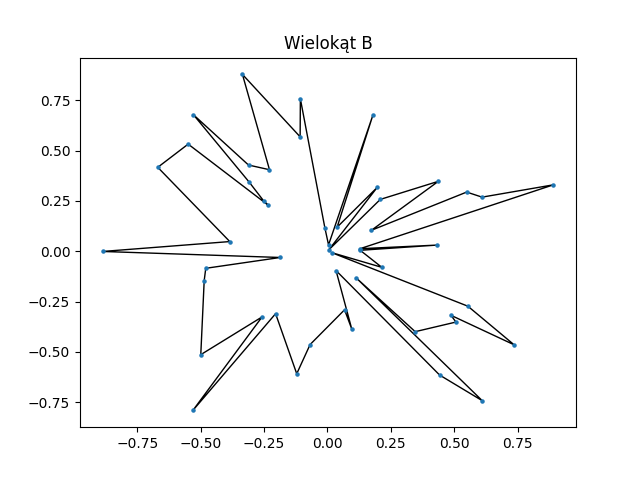

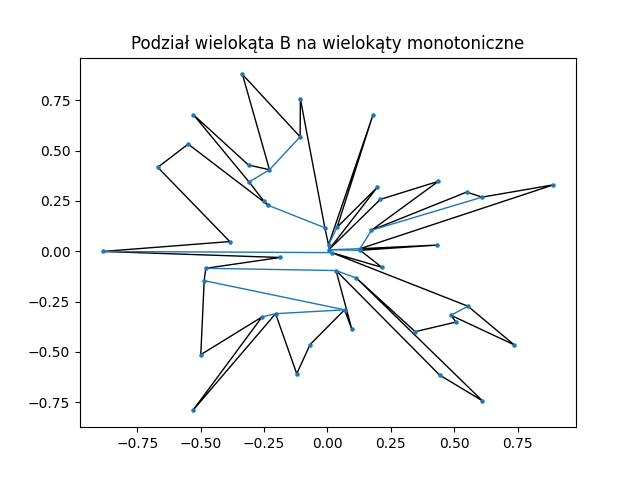

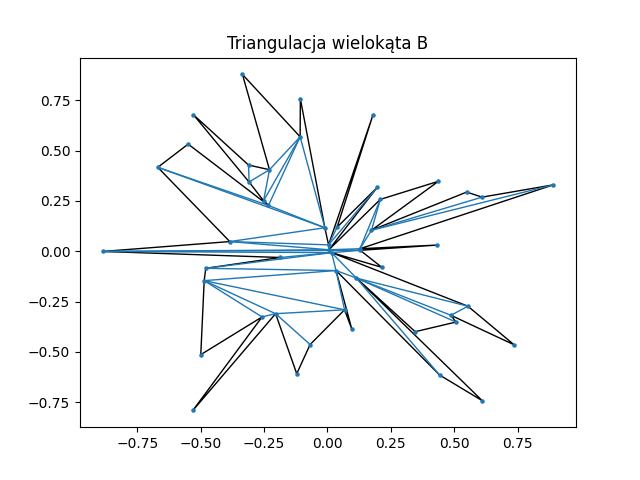

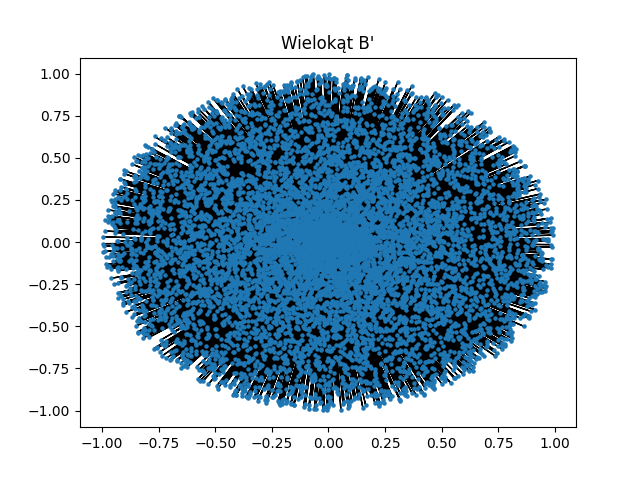

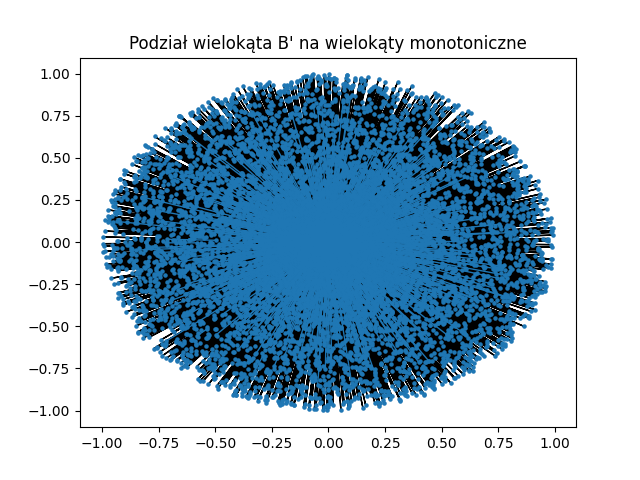

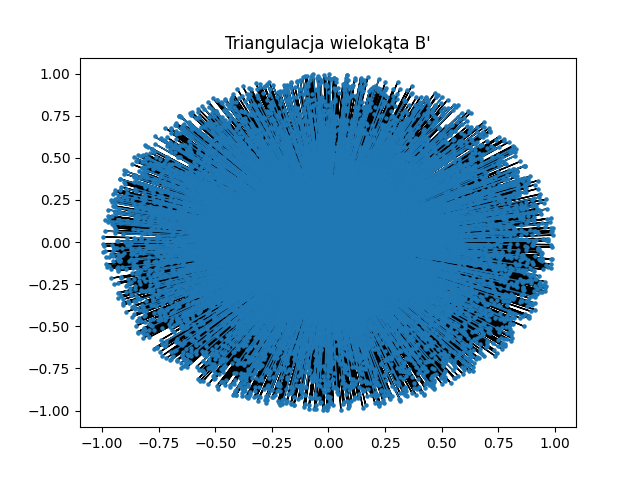

In [179]:
rng = np.random.default_rng()

def get_random_coords(n, x_center=0, y_center=0, radius_max=1):
    phi = []
    while len(phi) < n:
        phi = np.unique(-np.sort(rng.uniform(-2*np.pi, 0, n)))
    r = rng.uniform(0, radius_max, n)
    result = np.dstack((x_center+r*np.cos(phi), y_center+r*np.sin(phi)))
    return [(p[0], p[1]) for p in result.reshape(-1, result.shape[-1])]

points_b = get_random_coords(50)
present_set(points_b, "Wielokąt B")
present_partition(points_b, "Podział wielokąta B na wielokąty monotoniczne")
present_full_triangulation(points_b, "Triangulacja wielokąta B")
present_delaunay(points_b)
points_bp = get_random_coords(10000)
present_set(points_bp, "Wielokąt B'")
present_partition(points_bp, "Podział wielokąta B' na wielokąty monotoniczne")
present_full_triangulation(points_bp, "Triangulacja wielokąta B'")
present_delaunay(points_bp)

## Wieloboki $C$, $C'$

In [3]:
def get_wavy_coords(n, amplitude=1, frequency=1, start_x=0, end_x=10, height=10):
    step = abs(start_x-end_x)/n
    result = [(start_x+i*step, amplitude*np.cos(frequency*(start_x+i*step))) for i in range(n)]
    for i in range(n):
        result.append((end_x-i*step, amplitude*np.cos(frequency*(end_x-i*step))+height))
    return result

points_c = get_wavy_coords(50)
present_set(points_c, "Wielokąt C")
present_partition(points_c, "Podział wielokąta C na wielokąty monotoniczne")
present_full_triangulation(points_c, "Triangulacja wielokąta C")
present_delaunay(points_c)
points_cp = get_wavy_coords(10000)
present_set(points_cp, "Wielokąt C'")
present_partition(points_cp, "Podział wielokąta C' na wielokąty monotoniczne")
present_full_triangulation(points_cp, "Triangulacja wielokąta C'")
present_delaunay(points_cp)

NameError: name 'present_set' is not defined